In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import fast.s26_analysis.utils as utils 
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import skimage
from tqdm import tqdm
import tifffile as tif
import joblib

In [10]:
ground = tif.imread('fused_full.tif')

In [11]:
ground = ground / ground.max() * 100

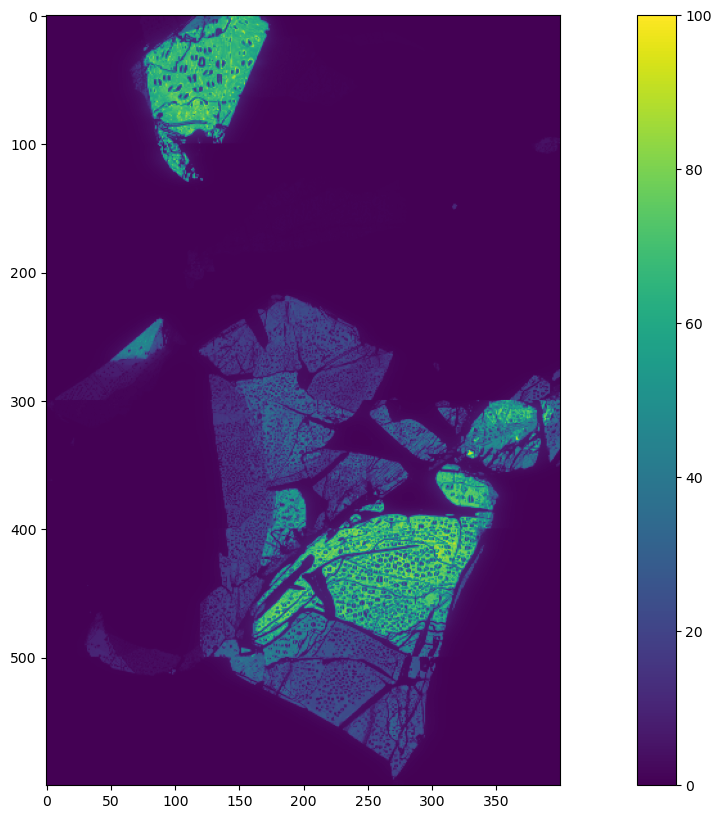

In [12]:
plt.figure(figsize=[20, 10])
plt.imshow(ground)
plt.colorbar()

In [13]:
generate_scan_pattern = lambda *a, **b: gcn(*a, verbose=False, **b)

In [ ]:
# Simulate random, raster, and fast sampling
# the "_random" suffix correspond to scans using the low discrepancy random (LDR) Hammersley sequence
# the "_uni" suffix corresponds to scans that use uniform random sampling.
# the "_raster" suffix corresponds to scans that use the raster grid

init_pattern = generate_scan_pattern(*ground.T.shape, 0.01)#[:,[1,0]]
sample_fast = utils.create_experiment_sample(numx=ground.shape[1], numy=ground.shape[0],
                                  inner_batch_size=50,
                                  initial_idxs=init_pattern)

recons_fast_all = []
masks_fast_all = []

recons_random_all = []
masks_random_all = []

recons_raster_all = []
masks_raster_all = []

recons_uni_all = []
masks_uni_all = []

ratios_all = []

count = 0
new_idxs = init_pattern


# This part is a hacky fix for a bug in the underlying code.
stop_ratio = 0.99
n_scan_points = int(stop_ratio * ground.size)

pbar = tqdm(total=n_scan_points, desc='Scanned points')
while sample_fast.mask.sum() < n_scan_points:
    sample_fast.measurement_interface.finalize_external_measurement(ground[new_idxs[:,0], new_idxs[:,1]])
    sample_fast.perform_measurements(new_idxs)
    sample_fast.reconstruct_and_compute_erd()
    new_idxs = sample_fast.find_new_measurement_idxs()
    
    count += 1
    if (count - 1) % 50 != 0:
        continue
        
    
    ratio = sample_fast.ratio_measured
    
    
    recons_fast_all.append(sample_fast.recon_image.copy())
    masks_fast_all.append(sample_fast.mask.copy())
    ratios_all.append(ratio)
    
    init_pattern = generate_scan_pattern(*ground.T.shape, num_scan_points = int(sample_fast.mask.sum()))
    sample_random = utils.create_experiment_sample(numx=ground.shape[1], numy=ground.shape[0],
                                      inner_batch_size=100,
                                      initial_idxs=init_pattern)

    sample_random.measurement_interface.finalize_external_measurement(ground[init_pattern[:,0], init_pattern[:,1]])
    sample_random.perform_measurements(init_pattern)
    sample_random.reconstruct_and_compute_erd()
    
    
    recons_this = sample_random.recon_image.copy() / sample_random.recon_image.max() * sample_random.measurement_info.unnormalized_values.max()
    recons_random_all.append(recons_this)
    masks_random_all.append(sample_random.mask.copy())
    num_measurements = sample_random.mask.sum().astype('int')
    
    uniform_idxs = np.random.choice(ground.size, size=num_measurements, replace=False)
    uni_pattern = np.array(np.unravel_index(uniform_idxs, ground.shape)).T
    sample_uni = utils.create_experiment_sample(numx=ground.shape[1], numy=ground.shape[0],
                                      inner_batch_size=100,
                                      initial_idxs=uni_pattern)

    sample_uni.measurement_interface.finalize_external_measurement(ground[uni_pattern[:,0], uni_pattern[:,1]])
    sample_uni.perform_measurements(uni_pattern)
    sample_uni.reconstruct_and_compute_erd()
    
    recons_this = sample_uni.recon_image.copy() / sample_uni.recon_image.max() * sample_uni.measurement_info.unnormalized_values.max()
    recons_uni_all.append(recons_this)
    masks_uni_all.append(sample_uni.mask.copy())
    
    ypoints = np.round(np.linspace(0, ground.shape[0] - 1, np.round(ground.shape[0] * ratio**0.5, 0).astype('int')), 0).astype('int')
    xpoints = np.round(np.linspace(0, ground.shape[1] - 1, np.round(ground.shape[1] * ratio**0.5, 0).astype('int')), 0).astype('int')
    
    grid = np.meshgrid(ypoints, xpoints)
    grid = np.array([[grid[0].flat[i], grid[1].flat[i]] for i in range(grid[0].size)])
    
    sample_grid = utils.create_experiment_sample(numx=ground.shape[1], numy=ground.shape[0],
                                      inner_batch_size=100,
                                      initial_idxs=grid)

    sample_grid.measurement_interface.finalize_external_measurement(ground[grid[:,0], grid[:,1]])
    sample_grid.perform_measurements(grid)
    sample_grid.reconstruct_and_compute_erd()
    
    recons_this = sample_grid.recon_image.copy() / sample_grid.recon_image.max() * sample_grid.measurement_info.unnormalized_values.max()
    recons_raster_all.append(recons_this)
    masks_raster_all.append(sample_grid.mask.copy())

    scanned_ratio = sample_fast.mask.sum() / ground.size
    pbar.update(int(sample_fast.mask.sum() - pbar.n))

In [20]:
len(masks_random_all)

9

In [21]:
len(ratios_all)

9

In [23]:
data_all = {'ratios': ratios_all,
            'fast_recons': recons_fast_all,
            'fast_masks': masks_fast_all,
            'smart_random_recons': recons_random_all,
            'smart_random_masks': masks_random_all,
            'unif_random_recons': recons_uni_all,
            'unif_random_masks': masks_uni_all,
            'raster_recons': recons_raster_all,
            'raster_masks': masks_raster_all}

In [24]:
joblib.dump(data_all, 'full_sims_fast_random_raster.pkl', protocol=-1, compress=3)

['full_sims_fast_random_raster.pkl']

In [25]:
!du -hsc full_sims_slads_random_raster.pkl

du: full_sims_slads_random_raster.pkl: No such file or directory
  0B	total
